In [1]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
import h5py
from Bio import SeqIO

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

2023-05-18 09:13:56.660815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-18 09:13:56.660846: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_save(history, filename):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.show()

In [3]:
def prot_t5_model():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(256)(M1_input)
    drop_out = Dropout(0.4)(M1_dense_1)
   
    M1_dense_2 = Dense(64, activation='relu')(drop_out)
    drop_out = Dropout(0.4)(M1_dense_2)
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    return model

In [4]:
def read_h5(path):
    hf = h5py.File(path, 'r')
    mat = np.array(hf["embedding"])
    hf.close()
    return mat

In [5]:
test_positive_ST_embedding_pos = read_h5("../embeddings/test_positive_ST_embedding.h5")
test_negative_ST_embedding_pos = read_h5("../embeddings/test_negative_ST_embedding.h5")

In [6]:
test_positive_ST_labels = np.ones(test_positive_ST_embedding_pos.shape[0])
test_negative_ST_labels = np.zeros(test_negative_ST_embedding_pos.shape[0])

test_ST_labels = np.concatenate((test_positive_ST_labels, test_negative_ST_labels), axis = 0)
X_test_full_ST_embedding = np.vstack((test_positive_ST_embedding_pos, test_negative_ST_embedding_pos))

In [7]:
train_positive_ST_embedding_pos = read_h5("../embeddings/train_positive_ST_embedding.h5")
train_negative_ST_embedding_pos = read_h5("../embeddings/train_negative_ST_embedding.h5")

In [8]:
train_positive_ST_labels = np.ones(train_positive_ST_embedding_pos.shape[0])
train_negative_ST_labels = np.zeros(train_negative_ST_embedding_pos.shape[0])

train_ST_labels = np.concatenate((train_positive_ST_labels, train_negative_ST_labels), axis = 0)
X_train_full_ST_embedding = np.vstack((train_positive_ST_embedding_pos, train_negative_ST_embedding_pos))

In [9]:
X_train_full_ST_embedding.shape, train_ST_labels.shape,  X_test_full_ST_embedding.shape, test_ST_labels.shape

((1779, 1024), (1779,), (446, 1024), (446,))

In [10]:
def get_input_for_embedding(fasta_file):
    # This is returning just integers to feed to embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    #print(char_to_int)
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        try:
            integer_encoded = [char_to_int[char] for char in data]
        except:
            continue
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    print(encodings.shape)
    return encodings


# convert sequences to integer encoding, for embedding
test_positive_ST_CNN = get_input_for_embedding('../dataset/test_Pos_ST.fasta')
test_negative_ST_CNN = get_input_for_embedding('../dataset/test_Neg_ST.fasta')

train_positive_ST_CNN = get_input_for_embedding('../dataset/train_Pos_ST.fasta')
train_negative_ST_CNN = get_input_for_embedding('../dataset/train_Neg_ST.fasta')

(222, 33)
(224, 33)
(890, 33)
(889, 33)


In [11]:
X_train_CNN = np.vstack((train_positive_ST_CNN, train_negative_ST_CNN))
X_test_CNN = np.vstack((test_positive_ST_CNN, test_negative_ST_CNN))
X_train_CNN.shape, X_test_CNN.shape, train_ST_labels.shape, test_ST_labels.shape

((1779, 33), (446, 33), (1779,), (446,))

In [12]:
X_train_CNN, train_ST_labels

(array([[ 2, 18, 16, ..., 15, 14, 15],
        [15,  7, 12, ...,  1, 16,  5],
        [ 5, 14,  5, ..., 15, 16, 18],
        ...,
        [ 0, 14, 10, ..., 19, 15,  7],
        [ 8,  0, 15, ...,  1, 10, 10],
        [ 3,  0, 10, ...,  3, 18, 11]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [29]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer, GlobalAveragePooling1D, Input, GlobalAveragePooling2D


def CNN_model():
    model = Sequential()
    model.add(Embedding(256, 21, input_length=33))
    model.add(Lambda(lambda x: tf.expand_dims(x, 3)))
    model.add(Conv2D(256, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model



class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(2 * ff_dim, activation="relu"), Dense(embed_dim)] #Dense(4 * ff_dim, activation="relu")
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [14]:
# Pretraining with Phosphorylation dataset

# S
pre_test_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_S.fasta')
pre_test_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_S.fasta')

pre_train_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_S.fasta')
pre_train_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_S.fasta')

# T
pre_test_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_T.fasta')
pre_test_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_T.fasta')

pre_train_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_T.fasta')
pre_train_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_T.fasta')


pre_test_pos_ST_CNN = np.vstack((pre_test_positive_S_CNN, pre_test_positive_T_CNN))
pre_test_neg_ST_CNN = np.vstack((pre_test_negative_S_CNN, pre_test_negative_T_CNN))

pre_train_pos_ST_CNN = np.vstack((pre_train_positive_S_CNN, pre_train_positive_T_CNN))
pre_train_neg_ST_CNN = np.vstack((pre_train_negative_S_CNN, pre_train_negative_T_CNN))

(3367, 33)
(3367, 33)
(13465, 33)
(13461, 33)
(856, 33)
(858, 33)
(3420, 33)
(3421, 33)


In [15]:
pre_test_pos_ST_CNN.shape, pre_test_neg_ST_CNN.shape, pre_train_pos_ST_CNN.shape, pre_train_neg_ST_CNN.shape

((4223, 33), (4225, 33), (16885, 33), (16882, 33))

In [16]:
pre_test_ST = np.vstack((pre_test_pos_ST_CNN, pre_test_neg_ST_CNN))

pre_test_positive_ST_labels = np.ones(pre_test_pos_ST_CNN.shape[0])
pre_test_negative_ST_labels = np.zeros(pre_test_neg_ST_CNN.shape[0])

pre_test_ST_labels = np.concatenate((pre_test_positive_ST_labels, pre_test_negative_ST_labels), axis = 0)
pre_test_ST.shape, pre_test_ST_labels.shape

((8448, 33), (8448,))

In [17]:
pre_train_ST = np.vstack((pre_train_pos_ST_CNN, pre_train_neg_ST_CNN))

pre_train_positive_ST_labels = np.ones(pre_train_pos_ST_CNN.shape[0])
pre_train_negative_ST_labels = np.zeros(pre_train_neg_ST_CNN.shape[0])

pre_train_ST_labels = np.concatenate((pre_train_positive_ST_labels, pre_train_negative_ST_labels), axis = 0)
pre_train_ST.shape, pre_train_ST_labels.shape

((33767, 33), (33767,))

In [18]:
### Assemble dataset for pretraining CNN and Transformer from Phophosite_org

# Pretraining with Phosphosite ORG dataset

# S
pre_test_positive_S_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/test_pos_S.fasta')
pre_test_negative_S_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/test_neg_S.fasta')

pre_train_positive_S_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/train_pos_S.fasta')
pre_train_negative_S_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/train_neg_S.fasta')

# T
pre_test_positive_T_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/test_pos_T.fasta')
pre_test_negative_T_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/test_neg_T.fasta')

pre_train_positive_T_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/train_pos_T.fasta')
pre_train_negative_T_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/train_neg_T.fasta')


pre_test_pos_ST_CNN_ORG = np.vstack((pre_test_positive_S_CNN_ORG, pre_test_positive_T_CNN_ORG))
pre_test_neg_ST_CNN_ORG = np.vstack((pre_test_negative_S_CNN_ORG, pre_test_negative_T_CNN_ORG))

pre_train_pos_ST_CNN_ORG = np.vstack((pre_train_positive_S_CNN_ORG, pre_train_positive_T_CNN_ORG))
pre_train_neg_ST_CNN_ORG = np.vstack((pre_train_negative_S_CNN_ORG, pre_train_negative_T_CNN_ORG))


pre_test_ST_CNN_ORG = np.vstack((pre_test_pos_ST_CNN_ORG, pre_test_neg_ST_CNN_ORG))
pre_train_ST_CNN_ORG = np.vstack((pre_train_pos_ST_CNN_ORG, pre_train_neg_ST_CNN_ORG))
pre_test_ST_CNN_ORG.shape, pre_train_ST_CNN_ORG.shape

(24736, 33)
(24738, 33)
(98936, 33)
(98933, 33)
(10572, 33)
(10573, 33)
(42286, 33)
(42284, 33)


((70619, 33), (282439, 33))

In [19]:
pre_test_positive_ST_ORG_labels = np.ones(pre_test_pos_ST_CNN_ORG.shape[0])
pre_test_negative_ST_ORG_labels = np.zeros(pre_test_neg_ST_CNN_ORG.shape[0])

pre_test_ST_ORG_labels = np.concatenate((pre_test_positive_ST_ORG_labels, pre_test_negative_ST_ORG_labels), axis = 0)
pre_test_ST_CNN_ORG.shape, pre_test_ST_ORG_labels.shape

((70619, 33), (70619,))

In [20]:
pre_train_positive_ST_ORG_labels = np.ones(pre_train_pos_ST_CNN_ORG.shape[0])
pre_train_negative_ST_ORG_labels = np.zeros(pre_train_neg_ST_CNN_ORG.shape[0])

pre_train_ST_ORG_labels = np.concatenate((pre_train_positive_ST_ORG_labels, pre_train_negative_ST_ORG_labels), axis = 0)
pre_train_ST_CNN_ORG.shape, pre_train_ST_ORG_labels.shape

((282439, 33), (282439,))

In [21]:
##### Combine Phosphosite ORG with ELM

pre_test_ST_CNN = np.vstack((pre_test_ST, pre_test_ST_CNN_ORG))
pre_test_ST_CNN_labels = np.concatenate((pre_test_ST_labels, pre_test_ST_ORG_labels), axis = 0)
pre_test_ST_CNN.shape, pre_test_ST_CNN_labels.shape

((79067, 33), (79067,))

In [22]:
pre_train_ST_CNN = np.vstack((pre_train_ST, pre_train_ST_CNN_ORG))
pre_train_ST_CNN_labels = np.concatenate((pre_train_ST_labels, pre_train_ST_ORG_labels), axis = 0)
pre_train_ST_CNN.shape, pre_train_ST_CNN_labels.shape

((316206, 33), (316206,))

In [23]:
### Assemble dataset for pretraining embeddings

pre_test_positive_S_embedding = read_h5("../embeddings/phospho.elm/test_positive_S_embedding.h5")
pre_test_negative_S_embedding = read_h5("../embeddings/phospho.elm/test_negative_S_embedding.h5")

pre_train_positive_S_embedding = read_h5("../embeddings/phospho.elm/train_positive_S_embedding.h5")
pre_train_negative_S_embedding = read_h5("../embeddings/phospho.elm/train_negative_S_embedding.h5")

pre_test_positive_T_embedding = read_h5("../embeddings/phospho.elm/test_positive_T_embedding.h5")
pre_test_negative_T_embedding = read_h5("../embeddings/phospho.elm/test_negative_T_embedding.h5")

pre_train_positive_T_embedding = read_h5("../embeddings/phospho.elm/train_positive_T_embedding.h5")
pre_train_negative_T_embedding = read_h5("../embeddings/phospho.elm/train_negative_T_embedding.h5")

pre_test_positive_S_embedding.shape, pre_test_negative_S_embedding.shape, pre_train_positive_S_embedding.shape, pre_train_negative_S_embedding.shape 

((3367, 1024), (3369, 1024), (13466, 1024), (13468, 1024))

In [24]:
pre_test_positive_T_embedding.shape, pre_test_negative_T_embedding.shape, pre_train_positive_T_embedding.shape, pre_train_negative_T_embedding.shape

((856, 1024), (858, 1024), (3420, 1024), (3422, 1024))

In [25]:
pre_test_pos_ST_Embed = np.vstack((pre_test_positive_S_embedding, pre_test_positive_T_embedding))
pre_test_neg_ST_Embed = np.vstack((pre_test_negative_S_embedding, pre_test_negative_T_embedding))

pre_train_pos_ST_Embed = np.vstack((pre_train_positive_S_embedding, pre_train_positive_T_embedding))
pre_train_neg_ST_Embed = np.vstack((pre_train_negative_S_embedding, pre_train_negative_T_embedding))

pre_test_pos_ST_Embed.shape, pre_test_neg_ST_Embed.shape, pre_train_pos_ST_Embed.shape, pre_train_neg_ST_Embed.shape

((4223, 1024), (4227, 1024), (16886, 1024), (16890, 1024))

In [26]:
pre_train_ST_Embed = np.vstack((pre_train_pos_ST_Embed, pre_train_neg_ST_Embed))

pre_train_positive_ST_Embed_labels = np.ones(pre_train_pos_ST_Embed.shape[0])
pre_train_negative_ST_Embed_labels = np.zeros(pre_train_neg_ST_Embed.shape[0])

pre_train_ST_labels_Embed = np.concatenate((pre_train_positive_ST_Embed_labels, pre_train_negative_ST_Embed_labels), axis = 0)
pre_train_ST_Embed.shape, pre_train_ST_labels_Embed.shape

((33776, 1024), (33776,))

In [27]:
pre_test_ST_Embed = np.vstack((pre_test_pos_ST_Embed, pre_test_neg_ST_Embed))

pre_test_positive_ST_Embed_labels = np.ones(pre_test_pos_ST_Embed.shape[0])
pre_test_negative_ST_Embed_labels = np.zeros(pre_test_neg_ST_Embed.shape[0])

pre_test_ST_labels_Embed = np.concatenate((pre_test_positive_ST_Embed_labels, pre_test_negative_ST_Embed_labels), axis = 0)
pre_test_ST_Embed.shape, pre_test_ST_labels_Embed.shape

((8450, 1024), (8450,))

PRE Training CNN model...
Epoch 1/30


2023-05-18 09:40:33.314903: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 338690048 exceeds 10% of free system memory.
2023-05-18 09:40:33.411028: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 338690048 exceeds 10% of free system memory.
2023-05-18 09:40:33.605231: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 338690048 exceeds 10% of free system memory.
2023-05-18 09:40:33.667577: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 338690048 exceeds 10% of free system memory.


  1/309 [..............................] - ETA: 9:37 - loss: 0.6962 - accuracy: 0.4951 - auc_roc: 0.4911

2023-05-18 09:40:34.598722: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 338690048 exceeds 10% of free system memory.


309/309 [==============================] - 623s 2s/step - loss: 0.6259 - accuracy: 0.6475 - auc_roc: 0.7050 - val_loss: 0.5994 - val_accuracy: 0.6848 - val_auc_roc: 0.7559
Epoch 2/30
309/309 [==============================] - 614s 2s/step - loss: 0.6012 - accuracy: 0.6789 - auc_roc: 0.7382 - val_loss: 0.5907 - val_accuracy: 0.6928 - val_auc_roc: 0.7621
Epoch 3/30
309/309 [==============================] - 611s 2s/step - loss: 0.5926 - accuracy: 0.6853 - auc_roc: 0.7484 - val_loss: 0.5928 - val_accuracy: 0.6954 - val_auc_roc: 0.7663
Epoch 4/30
309/309 [==============================] - 611s 2s/step - loss: 0.5881 - accuracy: 0.6897 - auc_roc: 0.7536 - val_loss: 0.5896 - val_accuracy: 0.6965 - val_auc_roc: 0.7689
Epoch 5/30
309/309 [==============================] - 610s 2s/step - loss: 0.5854 - accuracy: 0.6917 - auc_roc: 0.7566 - val_loss: 0.5897 - val_accuracy: 0.6981 - val_auc_roc: 0.7705
Epoch 6/30
309/309 [==============================] - 605s 2s/step - loss: 0.5824 - accuracy: 0.

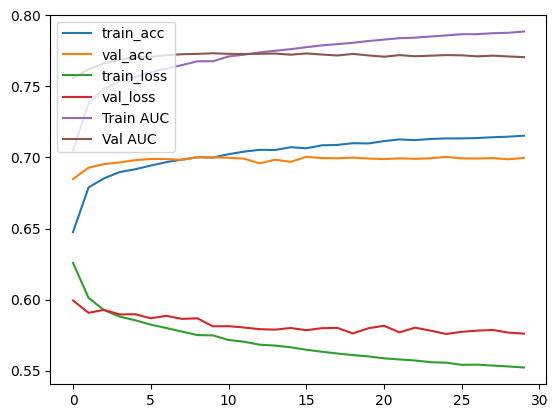


 Acc: 0.699748314720427, MCC: 0.3995015230047742, SN:0.7021578002074321, SP:0.6973391339538648, 
 CM:[[27570 11966]
 [11774 27757]]


In [31]:
# Pretraining CNN

n_epo_cnn = 30

metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

#model_A.summary()

print("PRE Training CNN model...")

checkpointer = ModelCheckpoint(filepath="../models/pre_model_A.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

#pre_history_A = model_A.fit(pre_train_ST, pre_train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
    #validation_data=(pre_test_ST, pre_test_ST_labels))
    
pre_history_A = model_A.fit(pre_train_ST_CNN, pre_train_ST_CNN_labels, batch_size=1024, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
    validation_data=(pre_test_ST_CNN, pre_test_ST_CNN_labels))

# Save model
#model_A.save_weights('../models/pre_model_A.h5')

y_pred = model_A.predict(pre_test_ST_CNN).reshape(pre_test_ST_CNN_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
pre_test_ST_CNN_labels = np.array(pre_test_ST_CNN_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(pre_test_ST_CNN_labels, y_pred)
mcc = matthews_corrcoef(pre_test_ST_CNN_labels, y_pred)
acc = accuracy_score(pre_test_ST_CNN_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(pre_history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Pre Training Embedding model...
Epoch 1/20
132/132 [==============================] - 2s 8ms/step - loss: 0.5467 - accuracy: 0.7325 - auc_roc: 0.8016 - val_loss: 0.5075 - val_accuracy: 0.7595 - val_auc_roc: 0.8338
Epoch 2/20
132/132 [==============================] - 1s 7ms/step - loss: 0.5150 - accuracy: 0.7528 - auc_roc: 0.8267 - val_loss: 0.5034 - val_accuracy: 0.7634 - val_auc_roc: 0.8370
Epoch 3/20
132/132 [==============================] - 1s 7ms/step - loss: 0.5065 - accuracy: 0.7606 - auc_roc: 0.8331 - val_loss: 0.5003 - val_accuracy: 0.7653 - val_auc_roc: 0.8385
Epoch 4/20
132/132 [==============================] - 1s 7ms/step - loss: 0.5008 - accuracy: 0.7654 - auc_roc: 0.8372 - val_loss: 0.5025 - val_accuracy: 0.7704 - val_auc_roc: 0.8395
Epoch 5/20
132/132 [==============================] - 1s 7ms/step - loss: 0.4936 - accuracy: 0.7681 - auc_roc: 0.8425 - val_loss: 0.5027 - val_accuracy: 0.7627 - val_auc_roc: 0.8384
Epoch 6/20
132/132 [==============================] - 1s 7

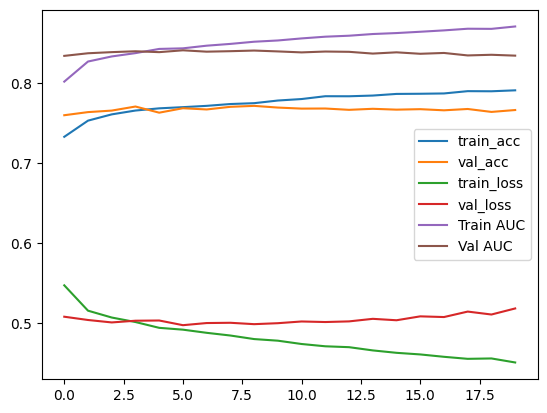


 Acc: 0.7660355029585799, MCC: 0.5321936551015639, SN:0.7764622306417239, SP:0.7556186420629288, 
 CM:[[3194 1033]
 [ 944 3279]]


 Acc: 0.7712426035502958, MCC: 0.5426580885904205, SN:0.7835661851764149, SP:0.7589306837000237, 
 CM:[[3208 1019]
 [ 914 3309]]


In [114]:
########### Model B

print("Pre Training Embedding model...")

metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]
n_epo_embed = 20
model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/pre_model_B.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_B = model_B.fit(pre_train_ST_Embed, pre_train_ST_labels_Embed, batch_size=256, epochs=n_epo_embed, verbose=1, 
                        callbacks=[checkpointer], validation_data=(pre_test_ST_Embed, pre_test_ST_labels_Embed))

# pre_train_ST_Embed.shape, pre_train_ST_labels_Embed.shape
# pre_test_ST_Embed.shape, pre_test_ST_labels_Embed.shape
#model_B.save_weights('../models/re_train_model_B.h5')

y_pred = model_B.predict(pre_test_ST_Embed).reshape(pre_test_ST_labels_Embed.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
pre_train_ST_labels_Embed = np.array(pre_train_ST_labels_Embed)
y_pred = np.array(y_pred)

cm = confusion_matrix(pre_test_ST_labels_Embed, y_pred)
mcc = matthews_corrcoef(pre_test_ST_labels_Embed, y_pred)
acc = accuracy_score(pre_test_ST_labels_Embed, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(history_B)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

loaded_model_B = prot_t5_model()
loaded_model_B.load_weights("../models/pre_model_B.h5")
y_pred = loaded_model_B.predict(pre_test_ST_Embed).reshape(pre_test_ST_labels_Embed.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
pre_test_ST_labels_Embed = np.array(pre_test_ST_labels_Embed)
y_pred = np.array(y_pred)

cm = confusion_matrix(pre_test_ST_labels_Embed, y_pred)
mcc = matthews_corrcoef(pre_test_ST_labels_Embed, y_pred)
acc = accuracy_score(pre_test_ST_labels_Embed, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [91]:
# transformer based embedding model
def transformer_model():
    vocab_size = 21
    embed_dim = 128 #config["embedding_dim"]
    ff_dim = 128 #config["feed_forward_dim"]
    max_len = 33 #config["maximum_path_length"]
    dropout = 0.4 #config["dropout"]
    n_heads = 2

    inputs = Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, n_heads, ff_dim)
    x, weights = transformer_block(x)
    x = GlobalAveragePooling1D()(x) #GlobalAveragePooling1D
    x = Dropout(dropout)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=[outputs])

PRE Training Transformer model...
Epoch 1/30
1236/1236 [==============================] - 380s 306ms/step - loss: 0.6143 - accuracy: 0.6592 - auc_roc: 0.7295 - val_loss: 0.5902 - val_accuracy: 0.6796 - val_auc_roc: 0.7495
Epoch 2/30
1236/1236 [==============================] - 380s 308ms/step - loss: 0.5939 - accuracy: 0.6785 - auc_roc: 0.7456 - val_loss: 0.5884 - val_accuracy: 0.6819 - val_auc_roc: 0.7553
Epoch 3/30
1236/1236 [==============================] - 380s 307ms/step - loss: 0.5906 - accuracy: 0.6814 - auc_roc: 0.7493 - val_loss: 0.5823 - val_accuracy: 0.6879 - val_auc_roc: 0.7583
Epoch 4/30
1236/1236 [==============================] - 378s 306ms/step - loss: 0.5869 - accuracy: 0.6842 - auc_roc: 0.7534 - val_loss: 0.5791 - val_accuracy: 0.6898 - val_auc_roc: 0.7620
Epoch 5/30
1236/1236 [==============================] - 378s 306ms/step - loss: 0.5853 - accuracy: 0.6860 - auc_roc: 0.7554 - val_loss: 0.5780 - val_accuracy: 0.6889 - val_auc_roc: 0.7621
Epoch 6/30
1236/1236 [====

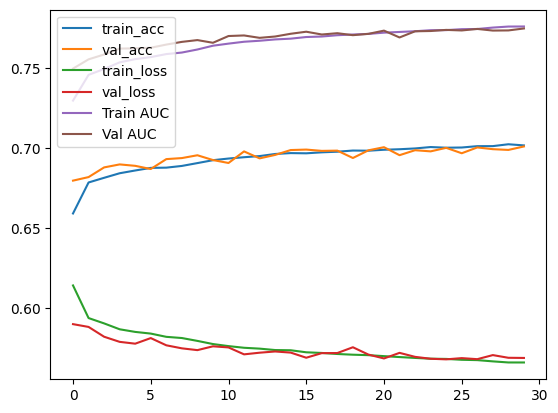


 Acc: 0.7009498273616047, MCC: 0.4032283224587941, SN:0.7414434241481369, SP:0.660461351679482, 
 CM:[[26112 13424]
 [10221 29310]]


In [192]:
# Pretraining transformer

n_epo_transformer = 30
model_C = transformer_model()
model_C.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

#model_C.summary()

checkpointer = ModelCheckpoint(filepath="../models/pre_model_C.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

print("PRE Training Transformer model...")

pre_history_C = model_C.fit(pre_train_ST_CNN, pre_train_ST_CNN_labels, batch_size=256, epochs=n_epo_transformer, verbose=1, callbacks=[checkpointer],
    validation_data=(pre_test_ST_CNN, pre_test_ST_CNN_labels))

# pre_train_ST_CNN, pre_train_ST_CNN_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
# validation_data=(pre_test_ST_CNN, pre_test_ST_CNN_labels)

# Save model
#model_C.save_weights('../models/pre_model_C.h5')

y_pred = model_C.predict(pre_test_ST_CNN).reshape(pre_test_ST_CNN_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
pre_test_ST_CNN_labels = np.array(pre_test_ST_CNN_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(pre_test_ST_CNN_labels, y_pred)
mcc = matthews_corrcoef(pre_test_ST_CNN_labels, y_pred)
acc = accuracy_score(pre_test_ST_CNN_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(pre_history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [193]:
## Predict on real data using CNN

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

## Predict on real data using transformers

y_pred = model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.742152466367713, MCC: 0.5205698336304371, SN:0.9234234234234234, SP:0.5625, 
 CM:[[126  98]
 [ 17 205]]

 Acc: 0.726457399103139, MCC: 0.4937984982931743, SN:0.9234234234234234, SP:0.53125, 
 CM:[[119 105]
 [ 17 205]]


Training CNN model...
Epoch 1/50
7/7 [==============================] - 1s 97ms/step - loss: 0.5488 - accuracy: 0.7341 - auc_roc: 0.7751 - val_loss: 0.5037 - val_accuracy: 0.7915 - val_auc_roc: 0.8629
Epoch 2/50
7/7 [==============================] - 0s 65ms/step - loss: 0.5256 - accuracy: 0.7510 - auc_roc: 0.8235 - val_loss: 0.4911 - val_accuracy: 0.7892 - val_auc_roc: 0.8658
Epoch 3/50
7/7 [==============================] - 0s 64ms/step - loss: 0.5154 - accuracy: 0.7566 - auc_roc: 0.8282 - val_loss: 0.4795 - val_accuracy: 0.7892 - val_auc_roc: 0.8708
Epoch 4/50
7/7 [==============================] - 0s 68ms/step - loss: 0.5062 - accuracy: 0.7504 - auc_roc: 0.8342 - val_loss: 0.4706 - val_accuracy: 0.7982 - val_auc_roc: 0.8744
Epoch 5/50
7/7 [==============================] - 0s 71ms/step - loss: 0.5032 - accuracy: 0.7600 - auc_roc: 0.8368 - val_loss: 0.4664 - val_accuracy: 0.8049 - val_auc_roc: 0.8766
Epoch 6/50
7/7 [==============================] - 1s 75ms/step - loss: 0.4984 - acc

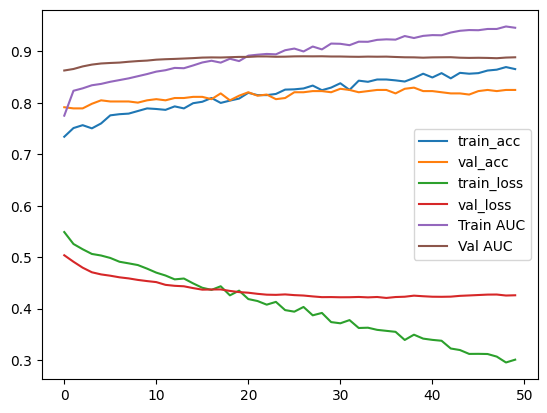


 Acc: 0.8251121076233184, MCC: 0.6506921730707258, SN:0.8423423423423423, SP:0.8080357142857143, 
 CM:[[181  43]
 [ 35 187]]



In [194]:
# Training DE-Phosphorylation

iteration = 1
n_epo_cnn = 50

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)
model_A.load_weights('../models/pre_model_A.h5')
#model_A.summary()

print("Training CNN model...")

#metrics = ['accuracy', tf.keras.metrics.AUC()]

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_A.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_A = model_A.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer], 
                        validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_A.save_weights('../models/re_train_model_A.h5')

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

In [195]:
loaded_model_A = CNN_model()
loaded_model_A.load_weights("../models/re_train_model_A.h5")
y_pred = loaded_model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.8295964125560538, MCC: 0.6591987793833408, SN:0.8243243243243243, SP:0.8348214285714286, 
 CM:[[187  37]
 [ 39 183]]


Training Embedding model...
Epoch 1/20
7/7 [==============================] - 1s 40ms/step - loss: 0.4978 - accuracy: 0.7684 - auc_roc: 0.8427 - val_loss: 0.4293 - val_accuracy: 0.8184 - val_auc_roc: 0.8873
Epoch 2/20
7/7 [==============================] - 0s 13ms/step - loss: 0.4727 - accuracy: 0.7774 - auc_roc: 0.8577 - val_loss: 0.4326 - val_accuracy: 0.8318 - val_auc_roc: 0.8853
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 0.4441 - accuracy: 0.8010 - auc_roc: 0.8744 - val_loss: 0.4276 - val_accuracy: 0.8341 - val_auc_roc: 0.8886
Epoch 4/20
7/7 [==============================] - 0s 11ms/step - loss: 0.4217 - accuracy: 0.8049 - auc_roc: 0.8875 - val_loss: 0.4273 - val_accuracy: 0.8274 - val_auc_roc: 0.8865
Epoch 5/20
7/7 [==============================] - 0s 11ms/step - loss: 0.4103 - accuracy: 0.8106 - auc_roc: 0.8926 - val_loss: 0.4263 - val_accuracy: 0.8318 - val_auc_roc: 0.8876
Epoch 6/20
7/7 [==============================] - 0s 11ms/step - loss: 0.4056

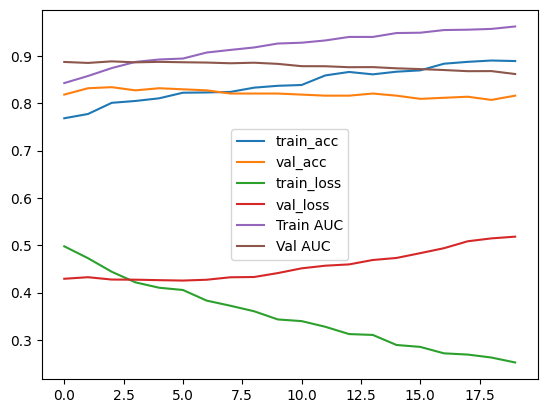


 Acc: 0.8340807174887892, MCC: 0.6681949806949807, SN:0.8378378378378378, SP:0.8303571428571429, 
 CM:[[186  38]
 [ 36 186]]


 Acc: 0.8340807174887892, MCC: 0.6683567494097307, SN:0.8198198198198198, SP:0.8482142857142857, 
 CM:[[190  34]
 [ 40 182]]


In [164]:
########### Model B

print("Training Embedding model...")

n_epo_embed = 20
model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)
model_B.load_weights('../models/pre_model_B.h5')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_B.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_B = model_B.fit(X_train_full_ST_embedding, train_ST_labels, batch_size=256, epochs=n_epo_embed, verbose=1, 
                        callbacks=[checkpointer], validation_data=(X_test_full_ST_embedding, test_ST_labels))

plot(history_B)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

loaded_model_B = prot_t5_model()
loaded_model_B.load_weights("../models/re_train_model_B.h5")
y_pred = loaded_model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Training Transformer model...
Epoch 1/40
7/7 [==============================] - 3s 279ms/step - loss: 0.5521 - accuracy: 0.7099 - auc_roc: 0.8375 - val_loss: 0.4981 - val_accuracy: 0.7466 - val_auc_roc: 0.8652
Epoch 2/40
7/7 [==============================] - 2s 236ms/step - loss: 0.5310 - accuracy: 0.7307 - auc_roc: 0.8312 - val_loss: 0.4837 - val_accuracy: 0.7803 - val_auc_roc: 0.8666
Epoch 3/40
7/7 [==============================] - 2s 262ms/step - loss: 0.5200 - accuracy: 0.7397 - auc_roc: 0.8309 - val_loss: 0.4737 - val_accuracy: 0.7758 - val_auc_roc: 0.8684
Epoch 4/40
7/7 [==============================] - 2s 253ms/step - loss: 0.5098 - accuracy: 0.7515 - auc_roc: 0.8352 - val_loss: 0.4669 - val_accuracy: 0.7892 - val_auc_roc: 0.8696
Epoch 5/40
7/7 [==============================] - 2s 243ms/step - loss: 0.5050 - accuracy: 0.7544 - auc_roc: 0.8352 - val_loss: 0.4617 - val_accuracy: 0.7825 - val_auc_roc: 0.8714
Epoch 6/40
7/7 [==============================] - 2s 232ms/step - loss

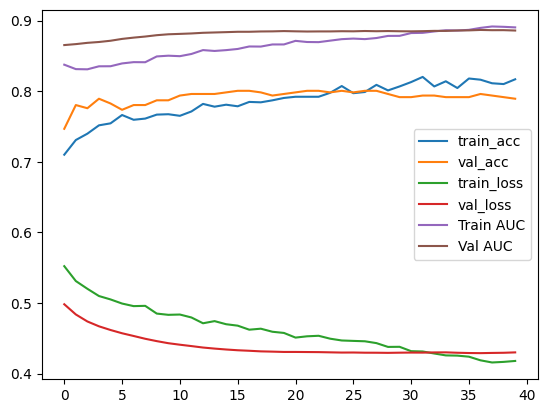


 Acc: 0.8295964125560538, MCC: 0.6591987793833408, SN:0.8243243243243243, SP:0.8348214285714286, 
 CM:[[187  37]
 [ 39 183]]


 Acc: 0.8004484304932735, MCC: 0.6009029027923717, SN:0.8018018018018018, SP:0.7991071428571429, 
 CM:[[179  45]
 [ 44 178]]


In [196]:
############# Training Transformer


model_C = transformer_model()
model_C.load_weights('../models/pre_model_C.h5')
model_C.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=metrics)

#model_C.summary()

n_epo_transformer = 40

print("Training Transformer model...")

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_C.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_C = model_C.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1
                        ,callbacks=[checkpointer]
                        , validation_data=(X_test_CNN, test_ST_labels))

plot(history_C)
print()

loaded_model_C = transformer_model()
loaded_model_C.load_weights("../models/re_train_model_C.h5")
y_pred = loaded_model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [199]:
# load models from file
def load_A_models():
    model = CNN_model()
    model.load_weights('../models/re_train_model_A.h5')
    return model


def load_B_models():
    model = prot_t5_model()
    model.load_weights('../models/re_train_model_B.h5')
    return model


def load_C_models():
    model = transformer_model()
    model.load_weights('../models/re_train_model_C.h5')
    return model


# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
    ensemble_inputs = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    #[model.get_layer(index = len(model.layers) - 2).output for model in members]
    #print(ensemble_outputs)
    #for item in ensemble_outputs:
    #    print(item)
    # outputs=re_stacked_model.get_layer(index=26).output
    merge = concatenate(ensemble_outputs)
    #hidden = Dropout(0.4, name = 'dp_2')(merge)
    #hidden = Dense(256, activation='relu', name = 'ds_1')(merge)
    #hidden = Dropout(0.4, name = 'dp_1')(hidden)
    hidden = Dense(32, activation='relu', name = 'ds_2')(merge)
    #hidden = Dropout(0.4, name = 'dp_1')(hidden)
    output = Dense(1, activation='sigmoid', name = 'ds_4')(hidden)
    model = Model(inputs=ensemble_inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    #model.summary()
    return model


# load all models
members = list()
model_A = load_A_models()
model_B = load_B_models()
model_C = load_C_models()

members.append(model_A)
members.append(model_B)
members.append(model_C)

n_epo_stacked = 20


print('Loaded %d models' % len(members))
stacked_model = define_stacked_model(members)


checkpointer = ModelCheckpoint(filepath="../models/pre_re_train_composite_model.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)


st_history = stacked_model.fit([X_train_CNN, X_train_full_ST_embedding, X_train_CNN], train_ST_labels, 
                               epochs=n_epo_stacked, verbose=1, callbacks = [checkpointer],
                               validation_data=([X_test_CNN, X_test_full_ST_embedding, X_test_CNN], test_ST_labels))

# X_train_full_ST_embedding, X_test_full_ST_embedding


Loaded 3 models
Epoch 1/20
56/56 [==============================] - 3s 23ms/step - loss: 0.6999 - accuracy: 0.4761 - auc_roc: 0.6103 - val_loss: 0.6603 - val_accuracy: 0.5291 - val_auc_roc: 0.9039
Epoch 2/20
56/56 [==============================] - 1s 18ms/step - loss: 0.6328 - accuracy: 0.6386 - auc_roc: 0.9160 - val_loss: 0.6128 - val_accuracy: 0.6906 - val_auc_roc: 0.9066
Epoch 3/20
56/56 [==============================] - 1s 18ms/step - loss: 0.5826 - accuracy: 0.7521 - auc_roc: 0.9290 - val_loss: 0.5655 - val_accuracy: 0.7578 - val_auc_roc: 0.9065
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 0.5276 - accuracy: 0.8038 - auc_roc: 0.9304 - val_loss: 0.5147 - val_accuracy: 0.8161 - val_auc_roc: 0.9054
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 0.4758 - accuracy: 0.8443 - auc_roc: 0.9298 - val_loss: 0.4758 - val_accuracy: 0.8139 - val_auc_roc: 0.9051
Epoch 6/20
56/56 [==============================] - 1s 19ms/step - loss: 0.4331

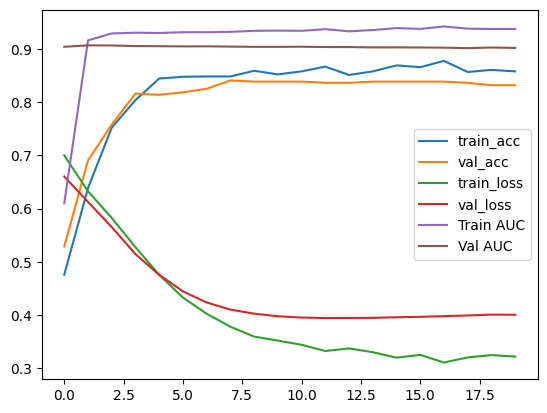



 Acc: 0.8408071748878924, MCC: 0.681988756917633, SN:0.8558558558558559, SP:0.8258928571428571, 
 CM:[[185  39]
 [ 32 190]]


In [200]:
plot(st_history)
print()

# Predict
re_stacked_model = define_stacked_model(members)
re_stacked_model.load_weights("../models/pre_re_train_composite_model.h5")
y_pred = re_stacked_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN]).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [201]:
# load pretrained model
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.manifold import TSNE
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns
import h5py

#re_stacked_model.summary()

print("Number of layers: ", len(re_stacked_model.layers))

# create truncated model
truncated_ANN_model = Model(inputs=re_stacked_model.input,
                                 outputs=re_stacked_model.get_layer(index=len(re_stacked_model.layers) - 1).output) #20

hidden_features = truncated_CNN_model.predict([X_test_full_ST_embedding])

hidden_labels = test_ST_labels #train_ST_labels

print(hidden_features.shape)

df = pd.DataFrame()
df['Target'] = hidden_labels

Number of layers:  27
(446, 64)


/home/anupkumar/anaconda3/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


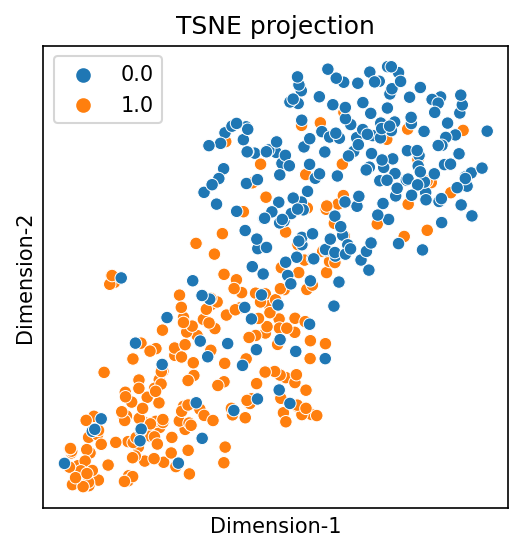

In [202]:
m = TSNE(learning_rate = "auto", perplexity = 100, random_state = 20)
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

plt.title("TSNE projection")
plt.legend().set_visible(True)
filename = "TSNE_Embedding_Pos_Neg.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

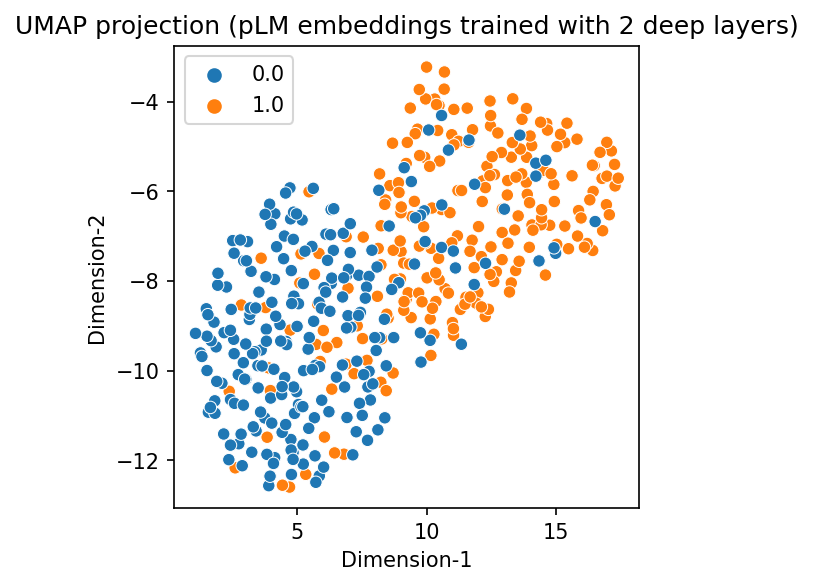

In [203]:
from umap import UMAP
from matplotlib.pyplot import figure

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

n_colors = 10

n_neighbors = 100

min_dist = 0.99

n_components = 2

metric = "hsl_dist" #'euclidean'

umap_2d = UMAP(n_components=n_components, n_neighbors = n_neighbors, min_dist = min_dist, init = 'random', random_state = 0)

proj_2d = umap_2d.fit_transform(hidden_features)

df_umap = pd.DataFrame()

df_umap["Dimension-1"] = proj_2d[:,0]
df_umap["Dimension-2"] = proj_2d[:,1]

sns_plot = sns.scatterplot(x="Dimension-1", y="Dimension-2", hue=hidden_labels, data=df_umap).set(title="UMAP projection (pLM embeddings trained with 2 deep layers)")
filename = "UMAP_Embedding_Pos_Neg.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')

/home/anupkumar/anaconda3/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


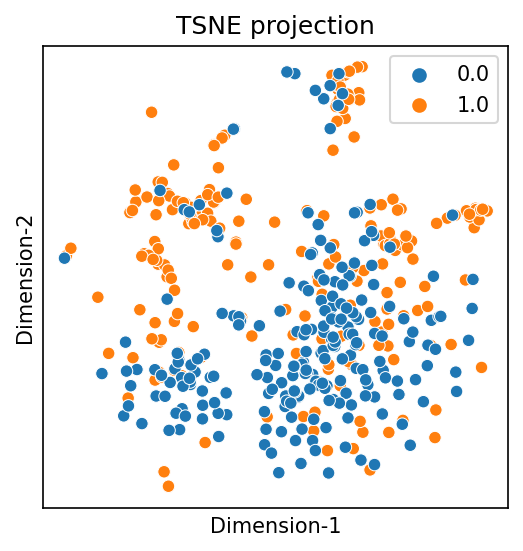

In [170]:
hidden_features_raw = X_test_full_ST_embedding
df = pd.DataFrame()
df['Target'] = test_ST_labels

m_raw = TSNE(learning_rate = "auto", perplexity = 100, random_state = 20)

tsne_features = m_raw.fit_transform(hidden_features_raw)

df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

plt.title("TSNE projection")
plt.legend().set_visible(True)
filename = "TSNE_Embedding_Pos_Neg_Raw.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

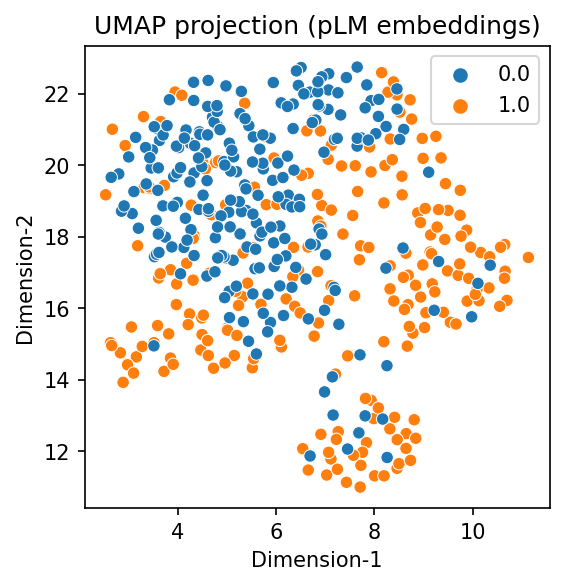

In [171]:

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

n_colors = 10

#n_neighbors = 1000

#min_dist = 0.99

#n_components=2

#metric='euclidean'

umap_2d_raw = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, init='random', random_state=0)

proj_2d = umap_2d_raw.fit_transform(hidden_features_raw)

df_umap = pd.DataFrame()

df_umap["Dimension-1"] = proj_2d[:,0]
df_umap["Dimension-2"] = proj_2d[:,1]

sns_plot = sns.scatterplot(x="Dimension-1", y="Dimension-2", hue=hidden_labels, data=df_umap).set(title="UMAP projection (pLM embeddings)")
filename = "UMAP_Embedding_Pos_Neg_pLM_embeddings.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')